# GET DATA FOR TRAINING

0. --------------------- USING TENSORFLOW FORMAT ---------------------  
1. X: (22750, 1, 33, 33)  y: (22750, 1089)
1. X_train: (22750, 1, 33, 33)  y_train: (22750, 1089)
1. X_test: (0, 1, 33, 33)  y_test: (0, 1089)


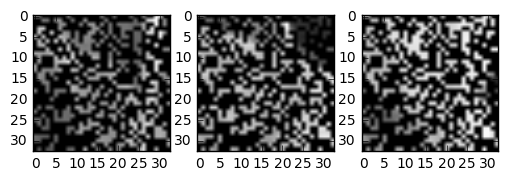

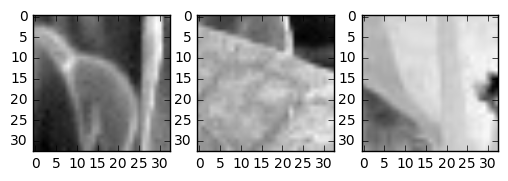

In [1]:
import sys
import os

%matplotlib inline
sys.path.append(os.path.dirname(os.getcwd()))

import utils
X_train, y_train, X_test, y_test = utils.get_data(33, 33, 'tensorflow', 'mr40', 0.0)

# THIS CELL TRAINS

In [ ]:
def generator_structure(loss = 'mean_squared_error', summary = 0):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, MaxPooling2D
    
    model = Sequential()
    
    model.add(Convolution2D(64, kernel_size=(11, 11), activation='relu', use_bias = True
                                , input_shape=(1,33,33), data_format='channels_first', padding='same'))
    
    model.add(Convolution2D(32, kernel_size=(1, 1), activation='relu', use_bias = True, padding='same'))

    model.add(Convolution2D(1, kernel_size=(7, 7), activation='relu', use_bias = True, padding='same'))
    
    model.add(Flatten())
    
    model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])

    if summary : model.summary()
    
    return model

def discriminator_structure(summary = 0):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, MaxPooling2D
    
    model = Sequential()
    
    model.add(Convolution2D(4, kernel_size=(4, 4), activation='relu', use_bias = True
                                , input_shape=(1,33,33), data_format='channels_first'))
    
    model.add(Convolution2D(4, kernel_size=(4, 4), activation='relu', use_bias = True))

    model.add(Convolution2D(4, kernel_size=(4, 4), activation='relu', use_bias = True))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))

    opt = 'adam' #keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    if summary : model.summary()
    
    return model

if __name__ == "__main__":
    
    import numpy as np
    import tensorflow as tf
    from keras import losses
    from tqdm import tqdm_notebook
    from keras.utils import np_utils
    import matplotlib.pyplot as plt
    from keras.callbacks import ModelCheckpoint
    
    np.random.seed(7)
    %matplotlib inline
    
    if utils.check_gpu(0):
        """ PARAMS """
        WIDTH = 33 
        HEIGHT = 33
        EPOCHS = 1
        BATCH_SIZE = 128
        MODEL_FOLDER = 'model_mr40'

        """ GENERATOR NETWORK TRAINING DATA """
        X_train_model_gen = X_train[:100].astype('float32')
        X_train_model_gen /= 255  
        y_train_model_gen = y_train[:100].astype('float32')
        y_train_model_gen /= 255
        
        
        """ CHECKPOINTS FOR GENERATOR AND DISCRIMINATOR MODELS """
        model_gen_filename_weights = MODEL_FOLDER + "/index_network_gan_gen_keras_weights_{epoch:02d}.hdf5"
        checkpoint_gen = ModelCheckpoint(model_gen_filename_weights, monitor='val_acc', mode='auto'
                                         , save_best_only = False
                                         , save_weights_only = True, verbose=0)
        callbacks_list_gen = [checkpoint_gen]
        
        model_dis_filename_weights = MODEL_FOLDER + "/index_network_gan_dis_keras_weights_{epoch:02d}.hdf5"
        checkpoint_dis = ModelCheckpoint(model_dis_filename_weights, monitor='val_acc', mode='auto'
                                         , save_best_only = False
                                         , save_weights_only = True, verbose=0)
        callbacks_list_dis = [checkpoint_dis]
        
        """ GET THE MODEL STRUCTURES """
        model_gen = generator_structure()
        model_dis = discriminator_structure()

        for epoch in range(EPOCHS):
            f, axarr = plt.subplots(1,2)
            rand_idx = np.random.randint(0, len(X_train_model_gen))
            """ 1.1 DISCRIMINATOR NETWORK TRAINING DATA """
            X_train_model_dis = np.array(y_train_model_gen).reshape((y_train_model_gen.shape[0], 1, WIDTH, HEIGHT))
            y_train_model_dis = np.ones((1, len(X_train_model_dis)))
            y_train_model_dis = np_utils.to_categorical(y_train_model_dis, 2)
            print ('Discriminator Data: X_train_model_dis', X_train_model_dis.shape, ' y_train_model_dis:', y_train_model_dis.shape)
            axarr[0].imshow(X_train_model_dis[rand_idx][0], cmap = plt.cm.gray)
            
            """ 1.2 GENERATE FAKE IMAGES """
            X_train_model_dis_tmp = []
            y_train_model_dis_tmp = []
            with tqdm_notebook(total = len(X_train_model_gen), leave = False, desc = 'Fake') as pbar:
                for i, each in enumerate(X_train_model_gen):
                    pbar.update(1)
                    each_tmp = each.reshape(1,1,WIDTH, HEIGHT)
                    X_train_model_dis_tmp.append(model_gen.predict(each_tmp))
                    y_train_model_dis_tmp.append(0)
            
            X_train_model_dis_tmp = np.array(X_train_model_dis_tmp).reshape(
                                                (len(X_train_model_dis_tmp), 1, WIDTH, HEIGHT))
            axarr[1].imshow(X_train_model_dis_tmp[rand_idx][0], cmap = plt.cm.gray)
            X_train_model_dis = np.vstack((X_train_model_dis, np.array(X_train_model_dis_tmp)))
            y_train_model_dis_tmp = np_utils.to_categorical(y_train_model_dis_tmp, 2)
            y_train_model_dis = np.vstack((y_train_model_dis, y_train_model_dis_tmp))
            print ('Discriminator Data: X_train_model_dis', X_train_model_dis.shape, ' y_train_model_dis:', y_train_model_dis.shape)

            """ 1.3 TRAIN THE DISCRIMINATOR ON THE `FAKE` IMAGES OF GENERATOR """
            model_dis.fit(X_train_model_dis, y_train_model_dis, batch_size = BATCH_SIZE, epochs = 10
                            , shuffle = True
                            , validation_split = 0.1
                            , callbacks = callbacks_list_dis
                            , verbose = 0)
            
            """ 1.4 GENERATE A CUSTOM LOSS FUNCTION OF TENSORFLOW """
            y_predict_model_dis = []
            with tqdm_notebook(total = len(X_train_model_dis), leave = False, desc = 'Loss:') as pbar:
                for i, each in enumerate(X_train_model_dis):
                    pbar.update(1)
                    y_predict_model_dis_tmp = model_dis.predict(each.reshape((1, 1, WIDTH, HEIGHT)))
                    y_predict_model_dis.append(y_predict_model_dis_tmp[0])
                        
                y_predict_model_dis = np.array(y_predict_model_dis)
                model_dis_loss = losses.categorical_crossentropy(
                                        tf.convert_to_tensor(y_train_model_dis, dtype=tf.float32)
                                        , tf.convert_to_tensor(y_predict_model_dis, dtype=tf.float32)
                                    )
                print (model_dis_loss, type(loss))
            
            def custom_model_gen_loss(y_true, y_pred):
                model_gen_loss = losses.mean_squared_error(y_true, y_pred) + model_dis_loss
                    
            """ TRAIN THE GENERATOR USING PHI AND INCORPORATE THE DISRIMINATOR LOSS IN TRAINING  """
            loss = 'mean_squared_error'
            loss = custom_model_gen_loss
            model_gen = generator_structure(loss)
            model_gen.fit(X_train_model_gen, y_train_model_gen, batch_size = BATCH_SIZE, epochs = 2
                          , shuffle = True
                          , validation_split = 0.1
                          , callbacks = callbacks_list_gen
                          , verbose = 1)
        else:
            print ('Oops! No GPU !!')

Using TensorFlow backend.



0. Keras backend: tensorflow


# THIS CELL IS FOR EXPERIMENTATION